In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import optuna
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import OneHotEncoder as OHE
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error as rmse ,mean_absolute_error as mae, r2_score as r2
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import VotingRegressor,StackingRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/job_market_salary_regression_dirty.csv')

In [6]:
df.shape

(15000, 7)

In [7]:
df.head()

,experience_years,education_level,skills_score,company_size,overtime_hours,remote_ratio,salary
0,8.986857,1.0,53.193312,50.0,0.614554,0.222314,87334.561264
1,6.446943,0.0,47.282658,50.0,16.209836,0.305449,78747.290505
2,9.590754,3.0,75.793381,200.0,2.480684,0.613889,138594.717898
3,13.092119,1.0,72.817636,10.0,2.449738,0.078061,105919.954716
4,6.063387,2.0,84.074213,NaN,1.550858,0.251870,122961.699206


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   experience_years  13754 non-null  float64
 1   education_level   13826 non-null  float64
 2   skills_score      13760 non-null  float64
 3   company_size      13809 non-null  float64
 4   overtime_hours    13768 non-null  float64
 5   remote_ratio      13820 non-null  float64
 6   salary            15000 non-null  float64
dtypes: float64(7)
memory usage: 820.4 KB


In [9]:
df.isna().sum()

,0
experience_years,1246
education_level,1174
skills_score,1240
company_size,1191
overtime_hours,1232
remote_ratio,1180
salary,0


In [10]:
imp = IterativeImputer(
    estimator = HistGradientBoostingRegressor(random_state=42),
    initial_strategy='median',
    max_iter=10,
    n_nearest_features=8,
    random_state=42
    )

In [11]:
df_array = imp.fit_transform(df)

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [12]:
df = pd.DataFrame(df_array,columns=df.columns)

In [13]:
df.isna().sum()

,0
experience_years,0
education_level,0
skills_score,0
company_size,0
overtime_hours,0
remote_ratio,0
salary,0


<Axes: >

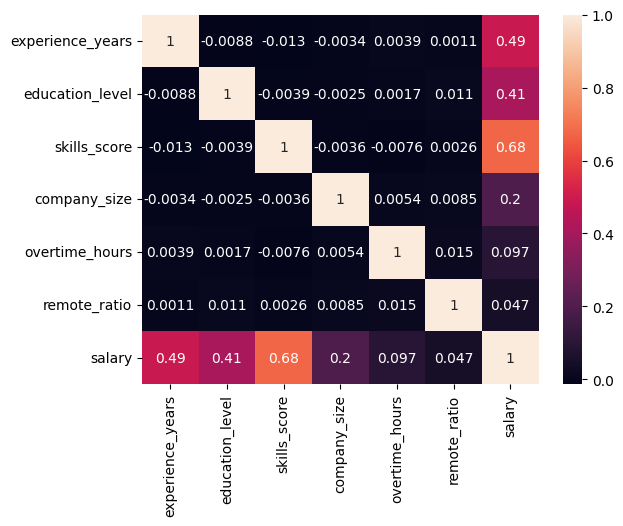

In [14]:
#همبستگی تقریبا خوبیه احتمالا مدل بادقت خوبی خواهد شد
sns.heatmap(df.corr(),annot=True)

<Axes: >

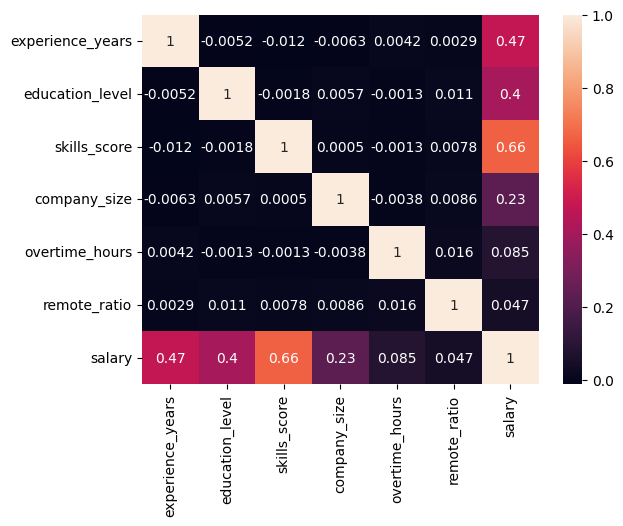

In [15]:
sns.heatmap(df.corr(method='spearman'),annot=True)

In [16]:
df

,experience_years,education_level,skills_score,company_size,overtime_hours,remote_ratio,salary
0,8.986857,1.00000,53.193312,50.000000,0.614554,0.222314,87334.561264
1,6.446943,0.00000,47.282658,50.000000,16.209836,0.305449,78747.290505
2,9.590754,3.00000,75.793381,200.000000,2.480684,0.613889,138594.717898
3,13.092119,1.00000,72.817636,10.000000,2.449738,0.078061,105919.954716
4,6.063387,2.00000,84.074213,134.391667,1.550858,0.251870,122961.699206
...,...,...,...,...,...,...,...
14995,3.361392,2.00000,59.025978,200.000000,5.871467,0.062688,93384.763313
14996,11.948604,1.00000,50.758079,1000.000000,0.624007,0.029523,104588.319654
14997,12.248832,3.00000,83.886481,50.000000,0.733081,0.290764,145365.687831
14998,3.463563,0.32543,77.974872,10.000000,3.530413,0.334117,88856.780799


<Axes: >

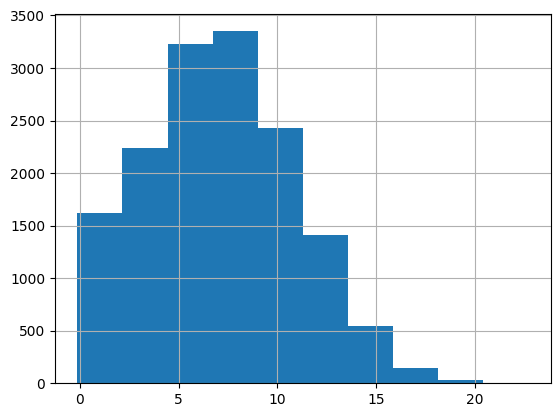

In [17]:
df['experience_years'].hist()

<Axes: >

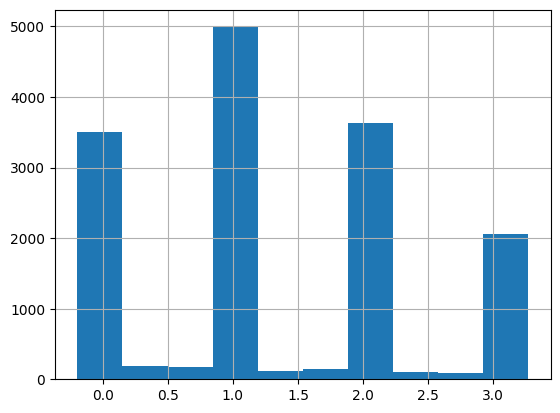

In [18]:
df['education_level'].hist()

<Axes: >

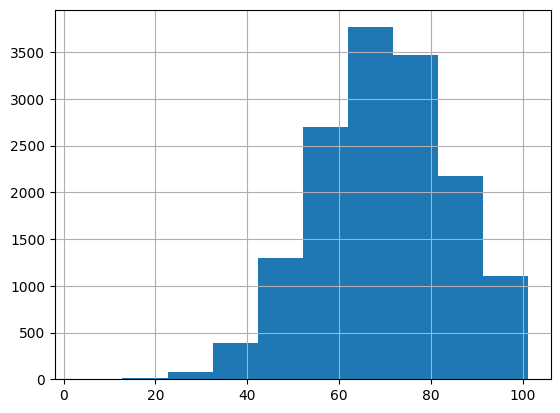

In [19]:
df['skills_score'].hist()

<Axes: >

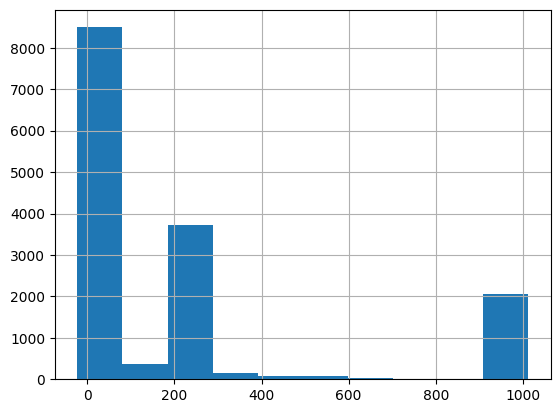

In [20]:
df['company_size'].hist()

<Axes: >

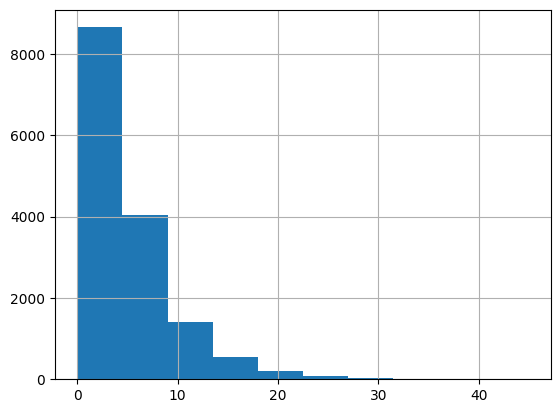

In [21]:
df['overtime_hours'].hist()

<Axes: >

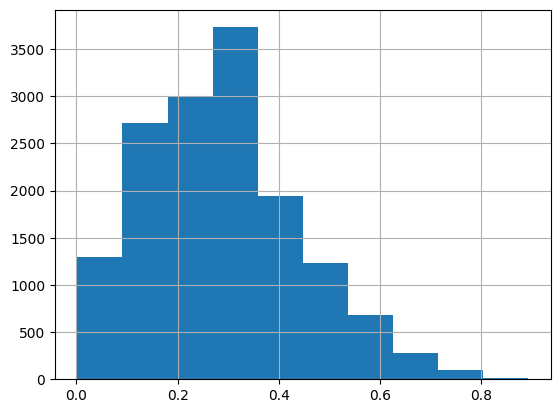

In [22]:
df['remote_ratio'].hist()

In [23]:
df['company_size'] = np.cbrt(df['company_size'])

In [24]:
df['overtime_hours'] = np.cbrt(df['overtime_hours'])

In [25]:
df.skew()

,0
experience_years,0.208495
education_level,0.252835
skills_score,-0.125938
company_size,0.883638
overtime_hours,0.088398
remote_ratio,0.591802
salary,0.008639


In [26]:
x=df.copy()

In [27]:
def out(outliers):
    for i in outliers.columns:
        Q1 = outliers[i].quantile(0.25)
        Q3 = outliers[i].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5*IQR
        upper = Q3 + 1.5*IQR
        out = outliers[(outliers[i] < lower) | (outliers[i] > upper)]
        outlier = len(out) / len(df)
        print(outlier)
        if outlier < 0.05 and outlier != 0 and outliers[i].nunique() > 10:
            outliers = outliers[(outliers[i] > lower) & (outliers[i] < upper)]
        if outlier <= 0.15 and outlier > 0.05 and outliers[i].nunique() > 10:
            outliers[i] = outliers[i].clip(lower,upper)
    return outliers

In [28]:
df = out(df)

0.0037333333333333333
0.0
0.003
0.0
0.004333333333333333
0.0102
0.0042


In [29]:
df

,experience_years,education_level,skills_score,company_size,overtime_hours,remote_ratio,salary
0,8.986857,1.00000,53.193312,3.684031,0.850198,0.222314,87334.561264
1,6.446943,0.00000,47.282658,3.684031,2.530810,0.305449,78747.290505
2,9.590754,3.00000,75.793381,5.848035,1.353704,0.613889,138594.717898
3,13.092119,1.00000,72.817636,2.154435,1.348052,0.078061,105919.954716
4,6.063387,2.00000,84.074213,5.122211,1.157508,0.251870,122961.699206
...,...,...,...,...,...,...,...
14995,3.361392,2.00000,59.025978,5.848035,1.804051,0.062688,93384.763313
14996,11.948604,1.00000,50.758079,10.000000,0.854535,0.029523,104588.319654
14997,12.248832,3.00000,83.886481,3.684031,0.901676,0.290764,145365.687831
14998,3.463563,0.32543,77.974872,2.154435,1.522679,0.334117,88856.780799


In [30]:
df['size_hours'] = df['company_size'] * df['overtime_hours']

In [31]:
df['level_skills'] = df['education_level'] * df['skills_score']

In [32]:
df['year_hours'] = df['experience_years'] * df['overtime_hours']

<Axes: >

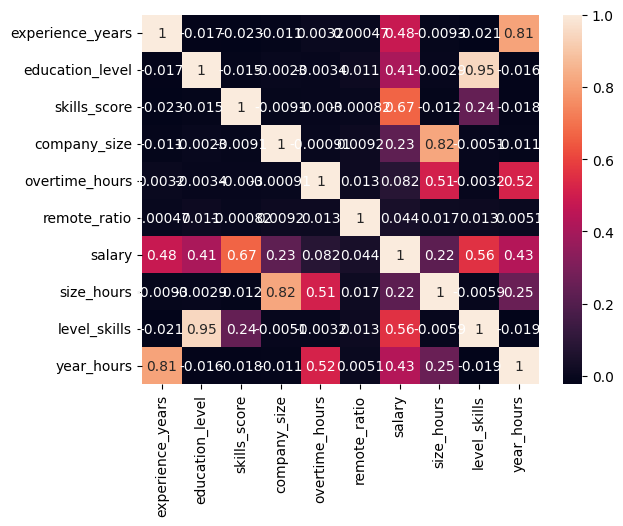

In [33]:
sns.heatmap(df.corr(),annot=True)

In [34]:
X = df.drop('salary',axis = 1)
y = df['salary']

In [35]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 42)

In [36]:
cols = X.select_dtypes(include=[np.number]).columns

In [37]:
cat_cols = [col for col in cols if X[col].nunique() < 10]

In [38]:
num_cols = [col for col in cols if col not in cat_cols]

In [39]:
preprocessor = ColumnTransformer([
    ('num',StandardScaler(),num_cols)],
    remainder = 'passthrough'
)

In [40]:
model1 = LinearRegression()
model2 = RandomForestRegressor(n_estimators = 300,max_depth = 10,min_samples_split = 5,min_samples_leaf = 2,ccp_alpha = 0.01,random_state = 42)
model3 = XGBRegressor(n_estimators = 300,learning_rate = 0.01,max_depth = 8,min_child_weight = 3,gamma =0.1,subsample = 0.6,reg_alpha = 0.1,random_state = 42)
model4 = LGBMRegressor(n_estimators = 400,learning_rate = 0.01,max_depth = 10,lambda_l1 = 0.1,lambda_l2 = 1.0,min_data_in_leaf = 40)
model5 = VotingRegressor(estimators=[('linear',LinearRegression()),('xgb',XGBRegressor(n_estimators = 300,learning_rate = 0.01,max_depth = 8,min_child_weight = 3,gamma =0.1,subsample = 0.6,reg_alpha = 0.1,random_state = 42))],weights=[0.3,0.7])
model6 = StackingRegressor(estimators=[('xgb',XGBRegressor(n_estimators = 300,learning_rate = 0.01,max_depth = 8,min_child_weight = 3,gamma =0.1,subsample = 0.6,reg_alpha = 0.1,random_state = 42)),('lgbm',LGBMRegressor(n_estimators = 400,learning_rate = 0.01,max_depth = 10,lambda_l1 = 0.1,lambda_l2 = 1.0,min_data_in_leaf = 40))])
pipeline1 = Pipeline([('preprocess',preprocessor),('model',model1)])
pipeline2 = Pipeline([('preprocess',preprocessor),('model',model2)])
pipeline3 = Pipeline([('preprocess',preprocessor),('model',model3)])
pipeline4 = Pipeline([('preprocess',preprocessor),('model',model4)])
pipeline5 = Pipeline([('preprocess',preprocessor),('model',model5)])
pipeline6 = Pipeline([('preprocess',preprocessor),('model',model6)])

In [41]:
models = [pipeline1,pipeline2,pipeline3,pipeline4,pipeline5,pipeline6]

In [42]:
def result(model, X_train, X_test, y_train, y_test,y):
    y_mean = y.mean()
    data = {'model': ['LinearRegression','RandomForestRegressor','XGBRegressor','LGBMRegressor','VotingRegressor(lr,xgb)','StackingRegressor'],'r2_train':[],'r2_test':[],'mae_train':[],'mae_test':[],'rmse_train':[],'rmse_test':[]}
    for model in models:
      try:
          model.fit(X_train,y_train)
          train_pred = model.predict(X_train)
          test_pred = model.predict(X_test)
          data['r2_train'].append(r2(y_train,train_pred))
          data['r2_test'].append(r2(y_test,test_pred))
          data['mae_train'].append(mae(y_train,train_pred)/y_mean)
          data['mae_test'].append(mae(y_test,test_pred)/y_mean)
          data['rmse_train'].append(rmse(y_train,train_pred)/y_mean)
          data['rmse_test'].append(rmse(y_test,test_pred)/y_mean)

      except Exception as e:
          print(e)
          data['r2_train'].append(np.nan)
          data['r2_test'].append(np.nan)
          data['mae_train'].append(np.nan)
          data['mae_test'].append(np.nan)
          data['rmse_train'].append(np.nan)
          data['rmse_test'].append(np.nan)
    return pd.DataFrame(data)

In [43]:
data = result(models, X_train, X_test, y_train, y_test,y)

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 10232, number of used features: 9
[LightGBM] [Info] Start training from score 107118.836

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [I

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [I

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [I

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [I

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [I

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1


In [44]:
data

,model,r2_train,r2_test,mae_train,mae_test,rmse_train,rmse_test
0,LinearRegression,0.938459,0.935862,0.034322,0.034342,0.044140,0.044451
1,RandomForestRegressor,0.963730,0.925403,0.026343,0.037197,0.033887,0.047938
2,XGBRegressor,0.959020,0.929930,0.028059,0.035943,0.036020,0.046461
3,LGBMRegressor,0.947420,0.932495,0.031698,0.035391,0.040800,0.045603
4,"VotingRegressor(lr,xgb)",0.956125,0.935174,0.028881,0.034457,0.037270,0.044689
5,StackingRegressor,0.958513,0.935701,0.027904,0.034267,0.036242,0.044506


<function matplotlib.pyplot.show(close=None, block=None)>

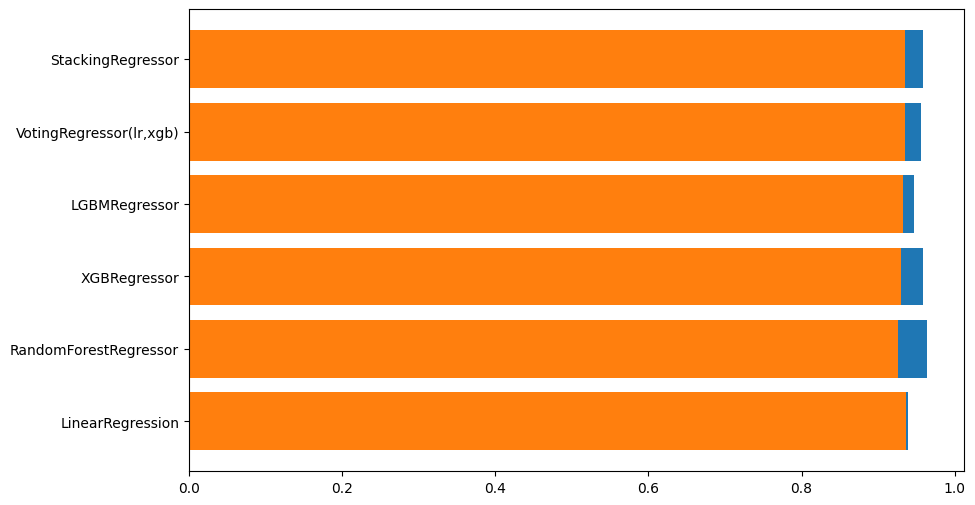

In [45]:
plt.figure(figsize=(10, 6))
plt.barh(data['model'], data['r2_train'], label='Train')
plt.barh(data['model'], data['r2_test'], label='Test')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

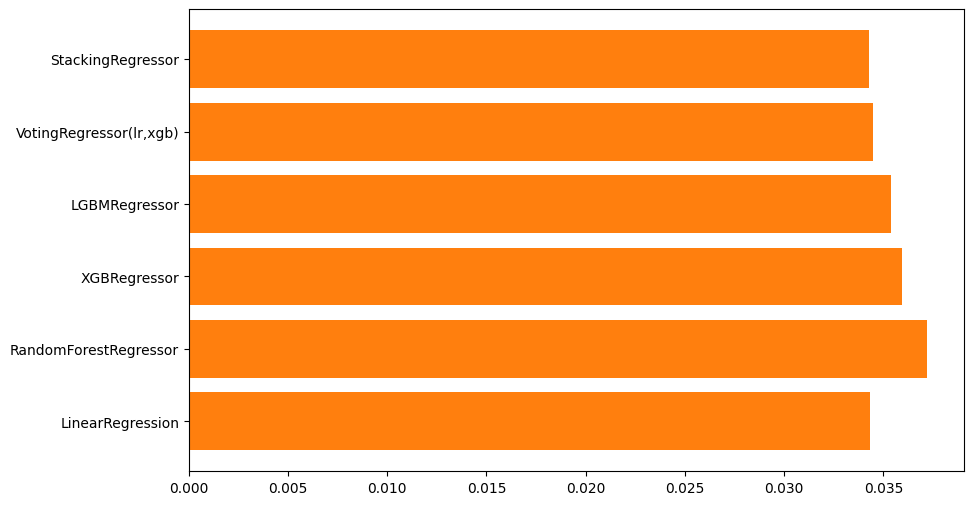

In [46]:
plt.figure(figsize=(10, 6))
plt.barh(data['model'], data['mae_train'], label='Train')
plt.barh(data['model'], data['mae_test'], label='Test')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

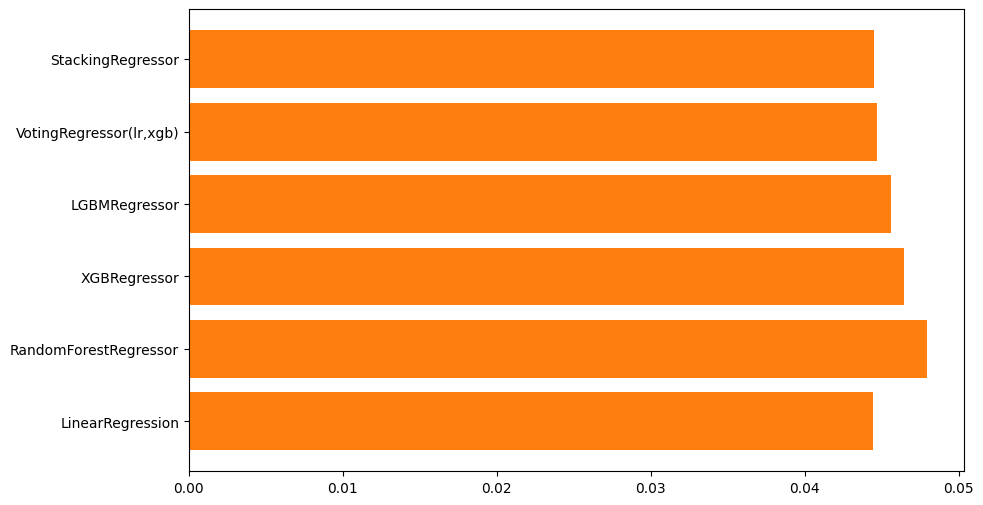

In [47]:
plt.figure(figsize=(10, 6))
plt.barh(data['model'], data['rmse_train'], label='Train')
plt.barh(data['model'], data['rmse_test'], label='Test')
plt.show

# مدل خطی بیشترین پایداری وکمترین خطا را داشته#


In [49]:
import optuna
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np

def objective(trial):
    fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
    copy_X = trial.suggest_categorical("copy_X", [True, False])
    positive = trial.suggest_categorical("positive", [True, False])
    n_jobs = trial.suggest_categorical("n_jobs", [None, -1])

    model = LinearRegression(fit_intercept=fit_intercept, copy_X=copy_X,positive=positive,n_jobs=n_jobs)

    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
    return -np.mean(scores)
# minimize یعنی کمترین خطا را بگیر برام
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Best params:", study.best_params)
print("Best RMSE:", study.best_value)


[I 2026-02-08 08:01:21,288] A new study created in memory with name: no-name-b5b157ca-5779-450d-bb1c-469befe36932
[I 2026-02-08 08:01:21,365] Trial 0 finished with value: 4721.728228554316 and parameters: {'fit_intercept': True, 'copy_X': True, 'positive': False, 'n_jobs': -1}. Best is trial 0 with value: 4721.728228554316.
[I 2026-02-08 08:01:21,529] Trial 1 finished with value: 4721.869548259122 and parameters: {'fit_intercept': False, 'copy_X': True, 'positive': False, 'n_jobs': None}. Best is trial 0 with value: 4721.728228554316.
[I 2026-02-08 08:01:21,647] Trial 2 finished with value: 4723.225649448289 and parameters: {'fit_intercept': False, 'copy_X': True, 'positive': True, 'n_jobs': None}. Best is trial 0 with value: 4721.728228554316.
[I 2026-02-08 08:01:21,834] Trial 3 finished with value: 4721.728228554316 and parameters: {'fit_intercept': True, 'copy_X': True, 'positive': False, 'n_jobs': -1}. Best is trial 0 with value: 4721.728228554316.
[I 2026-02-08 08:01:21,948] Trial

Best params: {'fit_intercept': True, 'copy_X': True, 'positive': False, 'n_jobs': -1}
Best RMSE: 4721.728228554316


In [50]:
model = LinearRegression(fit_intercept=True, copy_X=True,positive=False,n_jobs=None)
pipeline = Pipeline([('preprocess',preprocessor),('model',model)])

In [51]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['experience_years',
                                                   'education_level',
                                                   'skills_score',
                                                   'company_size',
                                                   'overtime_hours',
                                                   'remote_ratio', 'size_hours',
                                                   'level_skills',
                                                   'year_hours'])])),
                ('model', LinearRegression())])

In [52]:
model = pipeline.named_steps['model']

In [53]:
exp = shap.Explainer(model,X_train)

In [54]:
values = exp(X_test)

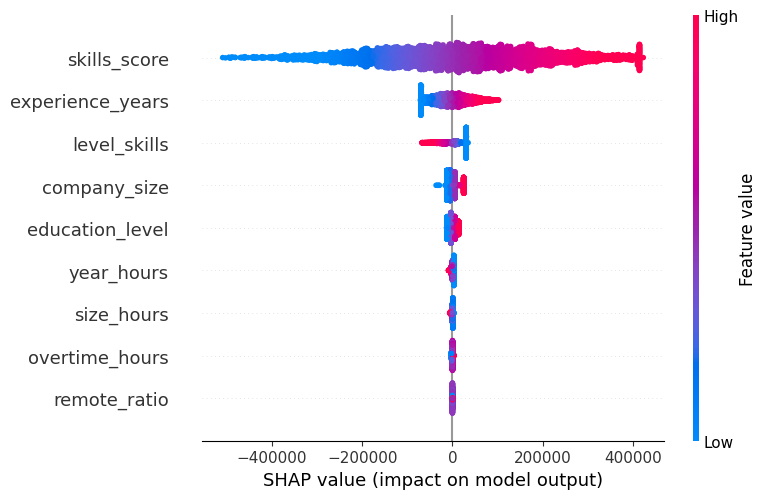

<function matplotlib.pyplot.show(close=None, block=None)>

In [55]:
shap.summary_plot(values,X_test)
plt.show

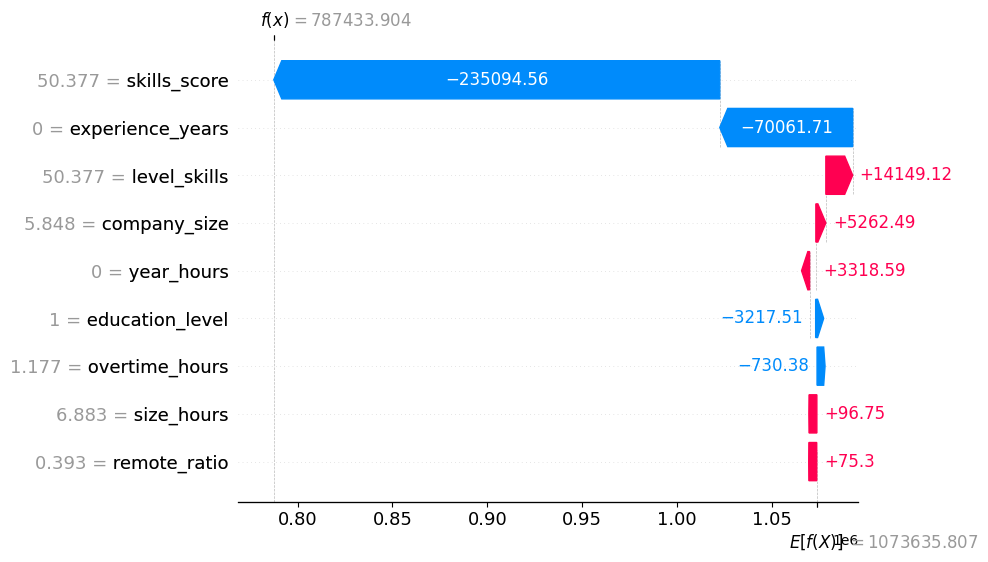

<function matplotlib.pyplot.show(close=None, block=None)>

In [56]:
shap.plots.waterfall(values[0])
plt.show

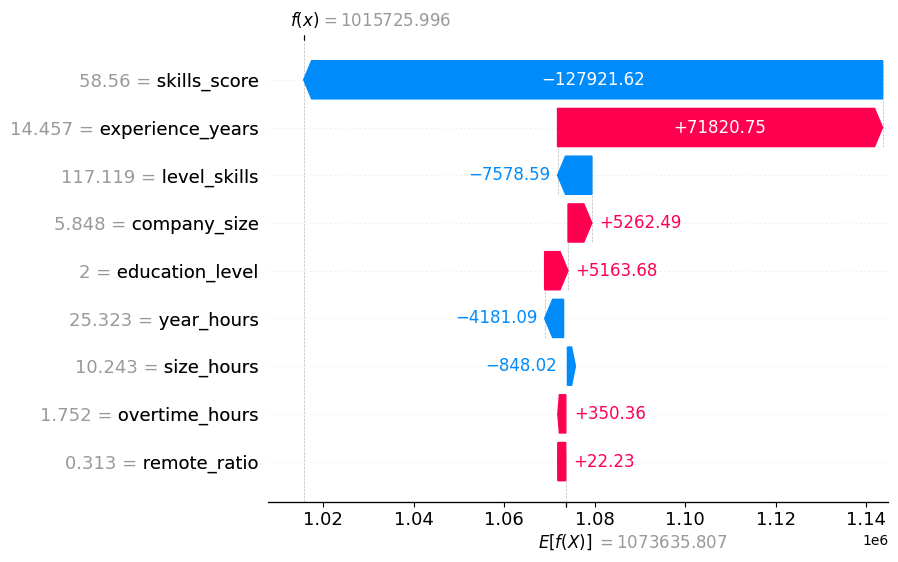

<function matplotlib.pyplot.show(close=None, block=None)>

In [57]:
shap.plots.waterfall(values[500])
plt.show

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature name

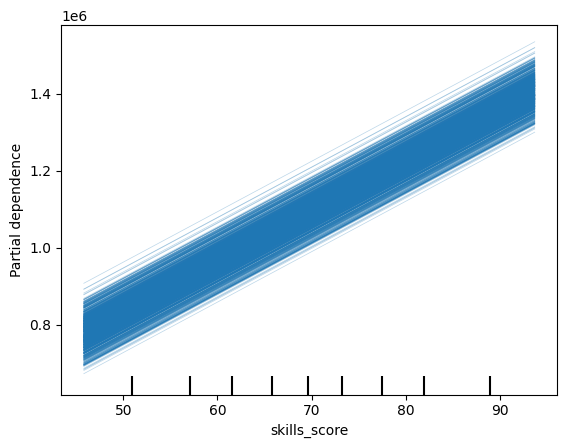

In [58]:
new_var = PartialDependenceDisplay.from_estimator(model,X_test,features=['skills_score'],kind='individual')
new_var

In [62]:
def calculate_vif(X):
  vif_data = pd.DataFrame()
  vif_data['feature'] = X.columns
  vif_data['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
  return vif_data.sort_values(by='VIF',ascending=False).round(2)

In [63]:
vif = calculate_vif(X)
vif

,feature,VIF
7,level_skills,48.87
1,education_level,48.11
4,overtime_hours,42.03
2,skills_score,38.22
6,size_hours,35.93
3,company_size,35.32
8,year_hours,34.07
0,experience_years,32.72
5,remote_ratio,4.66


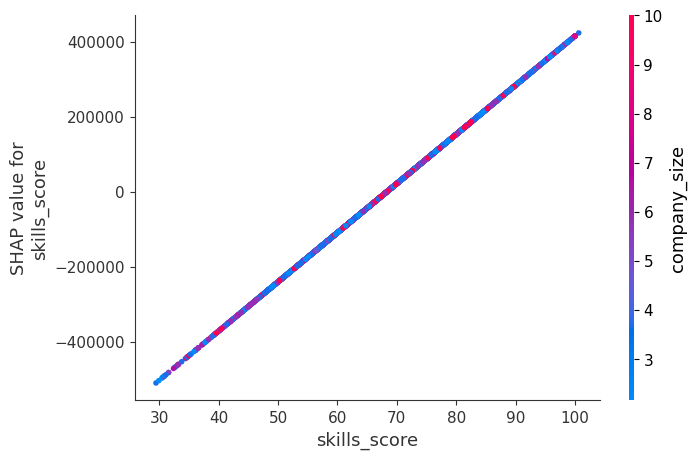

In [65]:
new_var0 = shap.dependence_plot('skills_score',values.values,X_test)
new_var0

In [66]:
with open('job_model.pkl','wb') as f:
    pickle.dump(pipeline,f)

In [67]:
with open('job_optuna_study.pkl','wb') as f:
    pickle.dump(study,f)

In [68]:
with open('job_model.pkl','rb') as f:
    loaded_model = pickle.load(f)

In [73]:
data.iloc[0,:]

,0
model,LinearRegression
r2_train,0.938459
r2_test,0.935862
mae_train,0.034322
mae_test,0.034342
rmse_train,0.04414
rmse_test,0.044451
